# Example 2: Mult-qubit dynamics
This first example will show some few-qubit dynamics, and follow example 2. Let us begin by importing the requisite packages. You can run these locally by running ```pip install amazon-braket-sdk``` and ``` pip install quera-ahs-utils```. For more details, see https://github.com/aws/amazon-braket-sdk-python and https://github.com/QuEraComputing/quera-ahs-utils.

In [1]:
from braket.ahs.driving_field import DrivingField
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.aws import AwsDevice
from quera_ahs_utils.plotting import plot_task

import quera_ahs_utils.drive as drive
import quera_ahs_utils.ir as ir

import numpy as np
import json, os


RAMP_TIME = 0.06e-6
MIN_TIME_STEP = 0.05e-6

def batch_submit(qpu: AwsDevice, ahs_programs: list, json_output_filename: str, shots: int=100):
    
    def submit_and_report(qpu: AwsDevice, ahs_program: AnalogHamiltonianSimulation, metadata):
        discretize_ahs_program = ahs_program.discretize(qpu)
        task = qpu.run(discretize_ahs_program, shots=shots)
        ahs_ir = discretize_ahs_program.to_ir()
        arn = task._arn
        task_bundle = {
            "task":eval(ahs_ir.json()),
            "metadata":str(metadata) # use eval to free data. 
        }
    
        return arn,task_bundle
    
    if not os.path.isfile(json_output_filename): # prevent accidental resubmission. 
        tasks = {}
        for ahs_program,*metadata in ahs_programs:
            arn, task_bundle = submit_and_report(qpu, ahs_program, metadata)
            tasks[arn] = task_bundle
            
        with open(json_output_filename,"w") as IO:
            json.dump(tasks,IO,indent=2)
    else:
        raise RuntimeError("resubmitting jobs not allowed, please use different filename.")

## Two Qubit Adiabatic Sweep
The first example is probing blockade physics by adiabatically preparing the ground state of two atoms as a function of distance between atoms.

In [2]:
def two_atom_adiabatic_ahs_program(distance: float) -> AnalogHamiltonianSimulation:
    """
    Define a two atom adiabatic state preparation.
    distance     - Distance between atom pairs, in meters
    """
    single_atom_register = AtomArrangement()
    single_atom_register.add((0,0))
    single_atom_register.add((0,distance))
    
    single_atom_ahs_program = AnalogHamiltonianSimulation(
        register=single_atom_register,
        hamiltonian=drive.adiabatic_drive(
            t_ramp_up = 1e-6, 
            t_ramp_down = 1e-6, 
            t_sweep = 2e-6, 
            Omega_max = 15e6,
            Delta_start = -15e6,
            Delta_end = 15e6
        )
    )
    
    return single_atom_ahs_program

distances = np.around(np.arange(4,11,1) * 1e-6, 13)

sweep_sim_programs = [(two_atom_adiabatic_ahs_program(distance), distance) for distance in distances]

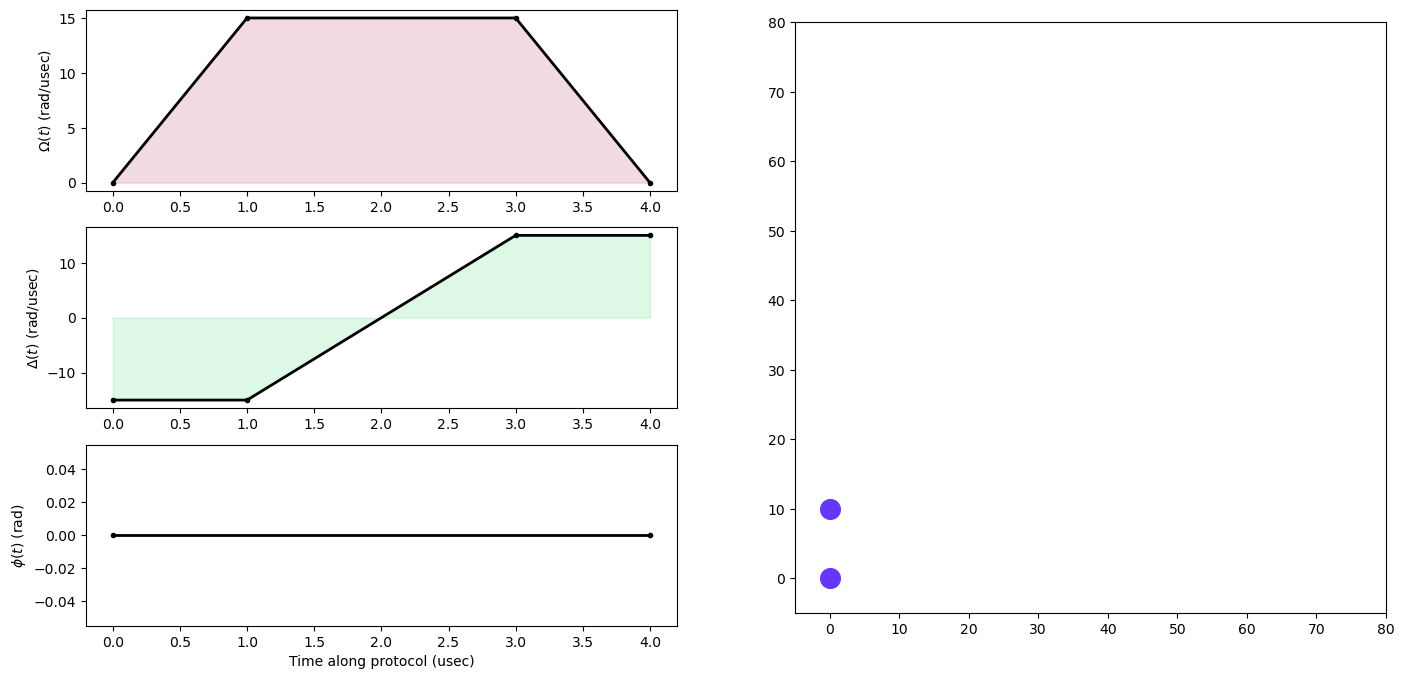

In [3]:
# Plot the task
plot_task(sweep_sim_programs[-1][0],show_register=True)

In [4]:
# Simulate with the local simulator
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

sweep_sim_tasks = [(sim.run(sweep_sim_program,shots=10000), None, distance) for sweep_sim_program,distance in sweep_sim_programs]


These same tasks can be sent to QuEra's hardware Aquila. However, it is wasteful to implement dynamics on only a single atom when the device can have many atoms. Instead, we parallelize the task by _multiplexing_ across the array. We duplicate each atom many times a "safe" distance away ($\geq 25.0\mu$m) so that each atom evolves independently. In this way, we require a factor of 16 fewer samples to accumulate adequate statistics.

In [ ]:
from braket.aws.aws_device import AwsDevice

import quera_ahs_utils.parallelize as pp

qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila",
)
    
sweep_qpu_programs = [pp.parallelize_ahs(sweep_sim_program,qpu,24e-6)+(distance,) for sweep_sim_program,distance in sweep_sim_programs]

Finally, we can submit to Aquila using the ```batch_submit``` function!

In [7]:
raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, sweep_qpu_programs, "two_atom_sweep_tasks.json", shots=100)

The ```batch_submit``` function saves the task ARN of each run, which can be loaded from Amazon BraKet.

In [49]:
from braket.aws import AwsQuantumTask
import json

sweep_qpu_tasks = []
with open("two_atom_sweep_tasks.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping,distance = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        sweep_qpu_tasks.append((task,batch_mapping,distance))


Next, analyze the data, by counting the instances of each bit string 00 01 10 11. A 0 bit string corresponds to the absence of an atom, which is equivalently a Rydberg state. These results are post-selected assuming atoms are loaded (which occurs with a $>99$% probability) using the ```pp.get_shots_braket_sdk_results``` function.

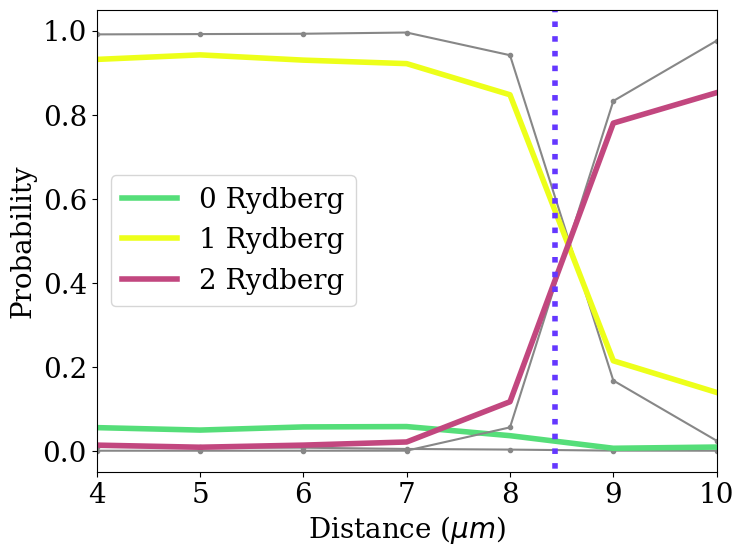

In [50]:
import matplotlib.pyplot as plt
from itertools import starmap
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = ["serif"]

def get_probabilities(task,batch_mapping,distance):
    shots = pp.get_shots_braket_sdk_results(task.result(),batch_mapping=batch_mapping,post_select=False)
    bit_string_counts = {
        (0,0):0,
        (0,1):0,
        (1,0):0,
        (1,1):0
    }
    nshots = 0
    for shot in shots[:]:
        if len(shot) != 2: continue
        shot = tuple(shot)
        bit_string_counts[shot] = bit_string_counts[shot] + 1
        nshots += 1
    
    bit_strings = [(1,1),(0,1),(1,0),(0,0)]
    probabilities = [bit_string_counts[bit_string]/nshots for bit_string in bit_strings]
    
    return distance/1e-6,np.array(probabilities)

qpu_results = list(starmap(get_probabilities,sweep_qpu_tasks))
sim_results = list(starmap(get_probabilities,sweep_sim_tasks))
# sort by distance, distance is the first element in the tuple:
qpu_results = sorted(qpu_results,key=lambda x:x[0])
sim_results = sorted(sim_results,key=lambda x:x[0])
# unpack values
distance,sim_probabilities = zip(*sim_results)
distance,qpu_probabilities = zip(*qpu_results)
sim_probabilities = np.array(sim_probabilities)
qpu_probabilities = np.array(qpu_probabilities)

# QuEra Colorscheme
RED = "#C2477F"
PURPLE = "#6437FF"
YELLOW = "#edff1a"
YELLOW2= "#a8b512"
GREEN  = "#55de79"
BLACK  = "#878787"

plt.figure(figsize=(8,6))
plt.plot(distance,sim_probabilities[:,0],marker=".",color=BLACK)
plt.plot(distance,qpu_probabilities[:,0],label=r"0 Rydberg",color=GREEN,linewidth=4)

plt.plot(distance,sim_probabilities[:,1]+sim_probabilities[:,2],marker=".",color=BLACK)
plt.plot(distance,qpu_probabilities[:,1]+qpu_probabilities[:,2],label="1 Rydberg",color=YELLOW,linewidth=4)

plt.plot(distance,sim_probabilities[:,3],marker=".",color=BLACK)
plt.plot(distance,qpu_probabilities[:,3], label="2 Rydberg",color=RED,linewidth=4)

r_blockade = (float(qpu.properties.paradigm.rydberg.c6Coefficient)/15e6)**(1/6)/1e-6
plt.vlines(r_blockade,-1,2,color=PURPLE,linestyle=":",linewidth=4)

plt.ylabel("Probability")
plt.xlabel("Distance ($\mu m$)")
plt.xlim(4,10)
plt.ylim(-0.05,1.05)
plt.legend()
plt.savefig("2_atom_adiabatic.svg")

Observe that results are consistent with the measurement error rate of P(Rydberg | Rydberg) ~90%. The purple dashed line is the blockade radius, which is consistant for both theoretical and experimental data.

## Multi-qubit Blockaded Rabi Oscillations
Next, let us do Rabi multi-qubit Rabi oscillations, which have a $\sqrt{N}$ enhansement driving between zero and one Rydberg oscillations. Here, we define blockaded oscillations with 1, 2, 3, 4, and 7 atoms.

In [5]:
def rabi_ahs_program(natoms: int, t_run: float, rabi_value: float, deutning_value: float):
    """
    A Rabi drive with many atoms within blockade radius
    natoms         - Number of atoms. Must be 1, 2, 3, 4, 7.
    t_run          - Total time of the pulse
    rabi_value     - Maximum Rabi amplitude
    detuning_value - A constant detuning
    """
    
    times = [0, RAMP_TIME, t_run + RAMP_TIME, t_run + 2 * RAMP_TIME]
    amplitude_values = [0, rabi_value, rabi_value, 0]
    detuning_values = [0, deutning_value, deutning_value, 0]
    phase_values = [0, 0, 0, 0]
    global_drive = drive.get_drive(times, amplitude_values, detuning_values, phase_values)
    
    # Define the register
    register = AtomArrangement()
    distance = 4e-6
    inv_sqrt_2_rounded = 2.6e-6
    if natoms == 1:
        register.add((0,0))
    elif natoms == 2:
        register.add((0,0))
        register.add((0,distance))
    elif natoms == 3:
        register.add((-inv_sqrt_2_rounded,0))
        register.add((inv_sqrt_2_rounded,0))
        register.add((0,distance))
    elif natoms == 4:
        register.add((0,0))
        register.add((distance,0))
        register.add((0,distance))
        register.add((distance,distance))
    elif natoms == 7:
        register.add((0,0))
        register.add((distance,0))
        register.add((-0.5*distance, distance))
        register.add((0.5*distance, distance))
        register.add((1.5*distance, distance))
        register.add((0, 2*distance))
        register.add((distance, 2*distance))
    else:
        raise ValueError(f"natoms must be 1,2,3,4, or 7")
        
    return AnalogHamiltonianSimulation(
        register=register,
        hamiltonian= global_drive )

# A drive of 15 rad/usec is adiquate for 1-4 atoms, but in order to preserve the blockade radius constraint for
# 7 atoms, we recommend a rabi drive of 5 rad/usec.
natoms = 7
rabi_drive = 5e6
detuning_value = 0.0e6

run_times = 0.05e-6 * np.arange(21)

manybody_rabi_sim_programs = [(rabi_ahs_program(natoms, run_time, rabi_drive, detuning_value), run_time, natoms) for run_time in run_times]

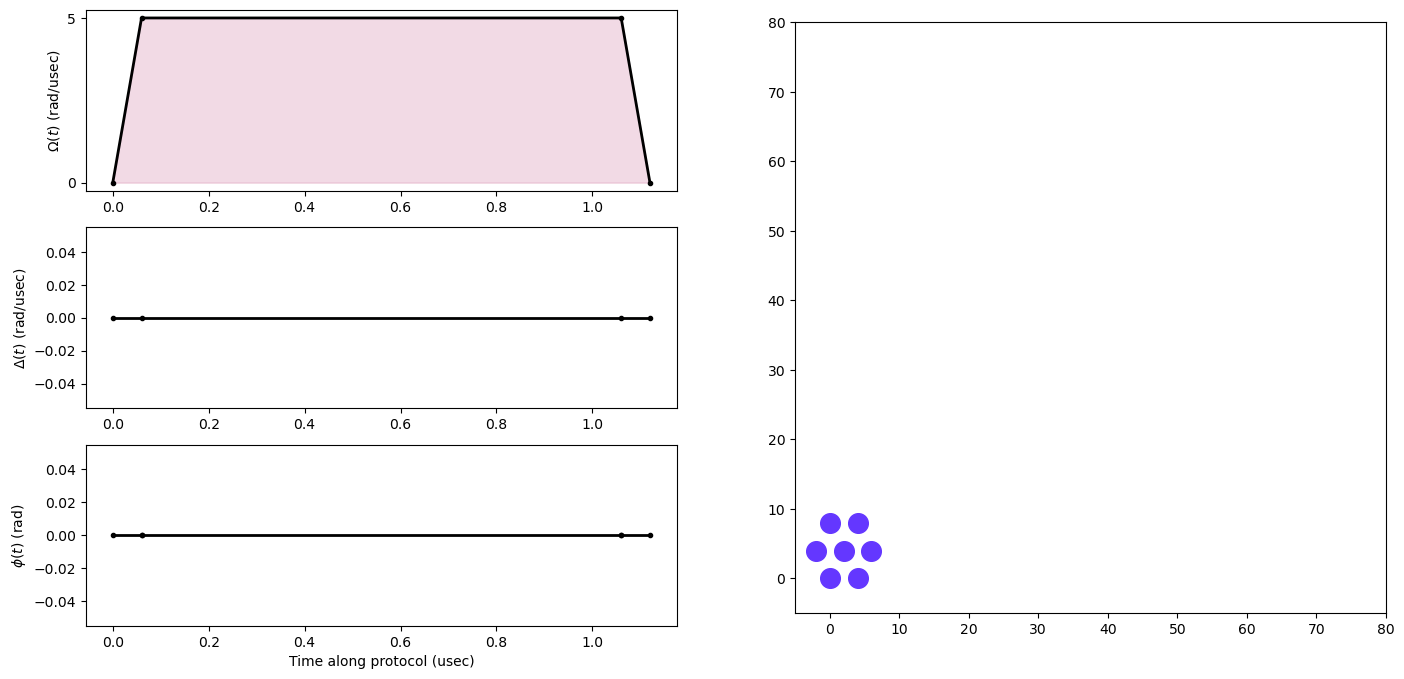

In [6]:
plot_task(manybody_rabi_sim_programs[-1][0],show_register=True)

In [7]:
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

manybody_rabi_sim_tasks = [(sim.run(manybody_rabi_sim_program,shots=10000), None)+(params[0],) for manybody_rabi_sim_program,*params in manybody_rabi_sim_programs]

In [29]:
import quera_ahs_utils.parallelize as pp

qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila",
)
    
manybody_rabi_qpu_programs = [pp.parallelize_ahs(manybody_rabi_sim_program,qpu,24e-6)+(run_time, natoms) for manybody_rabi_sim_program,run_time,natoms in manybody_rabi_sim_programs]

In [14]:
raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, manybody_rabi_qpu_programs, "many_body_rabi_tasks_7_atoms.json", shots=100)

In [32]:
from braket.aws import AwsQuantumTask
import json

manybody_rabi_qpu_tasks = []
with open("many_body_rabi_tasks_7_atoms.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping, run_time, natoms = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        manybody_rabi_qpu_tasks.append((task, batch_mapping, run_time))

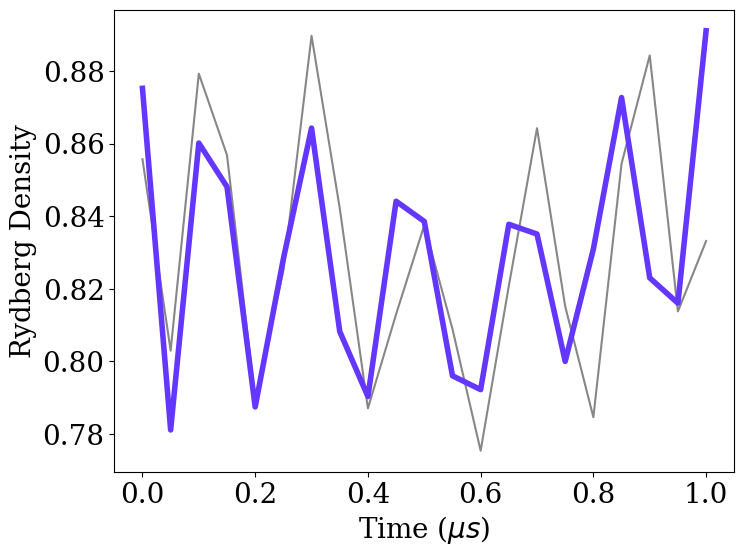

In [35]:
import matplotlib.pyplot as plt
from itertools import starmap
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = ["serif"]

def get_densities(task, batch_mapping, run_time):
    shots = pp.get_shots_braket_sdk_results(task.result(),batch_mapping=batch_mapping,post_select=False)
    
    return run_time/1e-6,shots.mean()

qpu_results = list(starmap(get_densities,manybody_rabi_qpu_tasks))
sim_results = list(starmap(get_densities,manybody_rabi_sim_tasks))

qpu_results = sorted(qpu_results,key=lambda x:x[0])
sim_results = sorted(sim_results,key=lambda x:x[0])

run_times,sim_density = zip(*sim_results)
run_times,qpu_density = zip(*qpu_results)
sim_density = np.array(sim_density)
qpu_density = np.array(qpu_density)


RED = "#C2477F"
PURPLE = "#6437FF"
YELLOW = "#edff1a"
YELLOW2= "#a8b512"
GREEN  = "#55de79"
BLACK  = "#878787"

plt.figure(figsize=(8,6))
plt.plot(run_times,sim_density,color=BLACK)
plt.plot(run_times,qpu_density,color=PURPLE,linewidth=4)


plt.ylabel("Rydberg Density")
plt.xlabel("Time ($\mu s$)")
plt.savefig("many_body_rabi_oscillation.svg")

# Nonequalibrium dynamics at blockade radius
We can also choose the distance between atoms in such a way that the interaction is similar strength to the Rabi drive. In this way, the dynamics nontrivially explores the Hilbert space instead of driving between zero and one Rydberg states. For a $15$rad/usec Rabi drive, this corresponds to a distance between atoms of ~8.5um.

In [38]:
def two_atom_dynamics_ahs(t_run: float, rabi_value: float, deutning_value: float):
    """
    A Rabi drive with two atoms at the blockade radius
    natoms         - Number of atoms. Must be 1, 2, 3, 4, 7.
    t_run          - Total time of the pulse
    rabi_value     - Maximum Rabi amplitude
    detuning_value - A constant detuning
    """
    times = [0, RAMP_TIME, t_run + RAMP_TIME, t_run + 2 * RAMP_TIME]
    amplitude_values = [0, rabi_value, rabi_value, 0]
    detuning_values = [0, deutning_value, deutning_value, 0]
    phase_values = [0, 0, 0, 0]
    global_drive = drive.get_drive(times, amplitude_values, detuning_values, phase_values)
    
    register = AtomArrangement()
    register.add((0,0))
    register.add((0,8.5e-6))
    
    return AnalogHamiltonianSimulation(
        register=register,
        hamiltonian=global_drive
    )

rabi_drive = 15e6
detuning_value = 0.0e6

run_times = 0.05e-6 * np.arange(31)

dynamics_sim_programs = [(two_atom_dynamics_ahs(run_time, rabi_drive, detuning_value), run_time) for run_time in run_times]

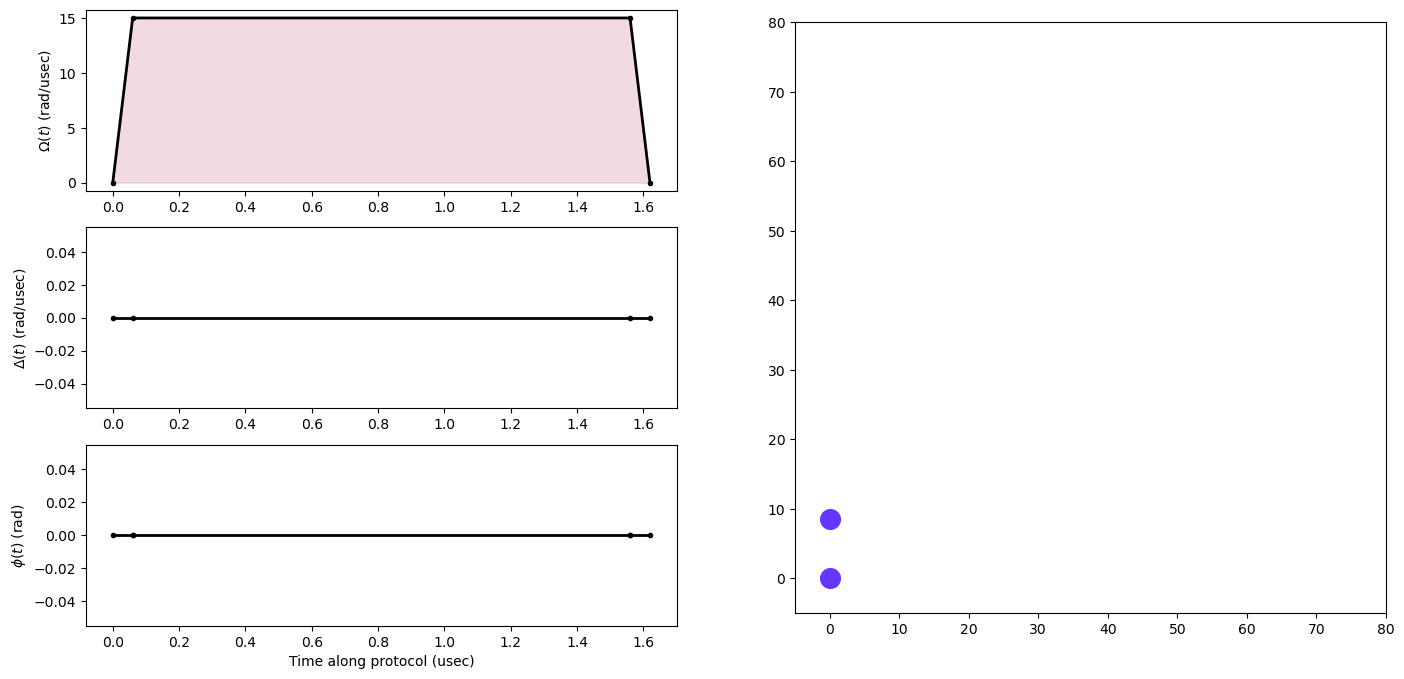

In [39]:
plot_task(dynamics_sim_programs[-1][0],show_register=True)

In [5]:
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

dynamics_sim_tasks = [(sim.run(dynamics_sim_program,shots=10000), None)+tuple(params) for dynamics_sim_program,*params in dynamics_sim_programs]

In [12]:
import quera_ahs_utils.parallelize as pp

qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila",
)

dynamics_qpu_programs = [pp.parallelize_ahs(dynamics_sim_program,qpu,24e-6)+(run_time,) for dynamics_sim_program,run_time in dynamics_sim_programs]

In [46]:
batch_submit(qpu, dynamics_qpu_programs, "two_atom_dynamics.json", shots=100)

In [9]:
from braket.aws import AwsQuantumTask
import json

dynamics_qpu_tasks = []
with open("two_atom_dynamics.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping, run_time = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        dynamics_qpu_tasks.append((task,batch_mapping,run_time))

In [ ]:
import matplotlib.pyplot as plt
from itertools import starmap
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = ["serif"]

def get_probabilities(task,batch_mapping,run_time):
    shots = pp.get_shots_braket_sdk_results(task.result(),batch_mapping=batch_mapping,post_select=False)
    bit_string_counts = {
        (0,0):0,
        (0,1):0,
        (1,0):0,
        (1,1):0
    }
    nshots = 0
    for shot in shots[:]:
        if len(shot) != 2: continue
        shot = tuple(shot)
        bit_string_counts[shot] = bit_string_counts[shot] + 1
        nshots += 1
    
    bit_strings = [(1,1),(0,1),(1,0),(0,0)]
    probabilities = [bit_string_counts[bit_string]/nshots for bit_string in bit_strings]
    
    return run_time/1e-6, np.asarray(probabilities)

qpu_results = list(starmap(get_probabilities,dynamics_qpu_tasks))
sim_results = list(starmap(get_probabilities,dynamics_sim_tasks))

qpu_results = sorted(qpu_results,key=lambda x:x[0])
sim_results = sorted(sim_results,key=lambda x:x[0])

run_times,sim_probabilities = zip(*sim_results)
run_times,qpu_probabilities = zip(*qpu_results)
sim_probabilities = np.array(sim_probabilities)
qpu_probabilities = np.array(qpu_probabilities)



RED = "#C2477F"
PURPLE = "#6437FF"
YELLOW = "#edff1a"
YELLOW2= "#a8b512"
GREEN  = "#55de79"
BLACK  = "#878787"
figure, axs = plt.subplots(1,3,figsize=(12,6),sharey=True)
axs[0].plot(run_times,sim_probabilities[:,0],marker=".",color=BLACK)
axs[0].plot(run_times,qpu_probabilities[:,0],color=PURPLE,linewidth=4)

axs[1].plot(run_times,sim_probabilities[:,1]+sim_probabilities[:,2],marker=".",color=BLACK)
axs[1].plot(run_times,qpu_probabilities[:,1]+qpu_probabilities[:,2],color=PURPLE,linewidth=4)

axs[2].plot(run_times,sim_probabilities[:,3],marker=".",color=BLACK, label="numerics")
axs[2].plot(run_times,qpu_probabilities[:,3],color=PURPLE,linewidth=4, label="qpu")


axs[0].set_ylabel("Probability")
axs[2].legend()

for ax in axs:
    ax.set_xlabel("Time ($\mu s$)")
    ax.set_xlim(0,1.5)
    ax.set_ylim(-0.05,1.05)
    
plt.savefig("2_atom_dynamics.svg")

# LP-Gate Simulation
As an example of interesting time-dependent dynamics using the blockade radius, let us implement the LP gate. As Aquila does not have hyperfine control, we instead do an analogue version with either one or two atoms. For more details, see https://arxiv.org/abs/1908.06101 or the accompanying whitepaper.

In [8]:
import quera_ahs_utils.plotting as plotting

def LP_drive(run_fraction: float) -> DrivingField:
    """
    Define the drive for the LP gate.
    run_fraction  - Fraction of time for dynamics. Must be between 0 and 1. This lets us see what the action of the gate is at intermediate steps along execution.
    """
    assert run_fraction>=0 and run_fraction<=1.0, "Run fraction is out of bounds"
    
    
    # LP Gate parameters
    delta = 0.377371 # Detuning
    xi = 3.90242     # Phase jump
    tau = 4.29268    # Time of each pulse
    
    amplitude_max = 10e6
    detuning_value = delta * amplitude_max # sets effective rabi frequency.
    T = tau / amplitude_max - MIN_TIME_STEP
    
    
    
    times = np.cumsum([0.0, MIN_TIME_STEP, T, MIN_TIME_STEP, MIN_TIME_STEP, MIN_TIME_STEP, T, MIN_TIME_STEP])
    values = [0.0, amplitude_max, amplitude_max, 0.0, 0.0, amplitude_max, amplitude_max, 0.0]
    amplitude = drive.time_series(times, values)
    
    run_time = times[-1]*run_fraction
    
    detuning = drive.constant_time_series(amplitude, detuning_value)
    phase = drive.time_series(
            times,
            [0.0, 0.0, 0.0, 0.0, xi, xi, xi, xi]
        )
    
    total_drive = DrivingField(
            amplitude=amplitude,
            phase=phase,
            detuning=detuning
        )
    
    
    sliced_drive = drive.slice_drive(total_drive, 0.0, run_time)
    
    drive_values = drive.get_driving_field_values(total_drive, run_time)
    
    
    if 1.0e-6 > MIN_TIME_STEP + run_time:
        truncation_time = MIN_TIME_STEP

        truncation_drive = DrivingField(
            amplitude=drive.time_series([0,truncation_time],[drive_values.amplitude,0.0]),
            phase=drive.time_series([0,truncation_time],[drive_values.phase,drive_values.phase]),
            detuning=drive.time_series([0,truncation_time],[drive_values.detuning,0.0])
        )
        return drive.concatenate_drives(sliced_drive, truncation_drive)
    else:
        return total_drive

def two_atom_LP_program(run_time: float) -> AnalogHamiltonianSimulation:
    """
    The LP gate implemented on two atoms (eg the |11> state)
    """
    register = AtomArrangement()
    register.add((0,0))
    register.add((0,4.0e-6))
    global_drive = LP_drive(run_time)
    return AnalogHamiltonianSimulation(
        register=register,
        hamiltonian=global_drive
    )

def one_atom_LP_program(run_time: float) -> AnalogHamiltonianSimulation:
    """
    The LP gate implemented on one atoms (eg the |01> or |10> state)
    """
    register = AtomArrangement()
    register.add((0,0))
    global_drive = LP_drive(run_time)
    return AnalogHamiltonianSimulation(
        register=register,
        hamiltonian=global_drive
    )


run_times = np.linspace(0,1,21)[1::]

lp_gate_sim_programs = [(one_atom_LP_program(run_time), run_time) for run_time in run_times]

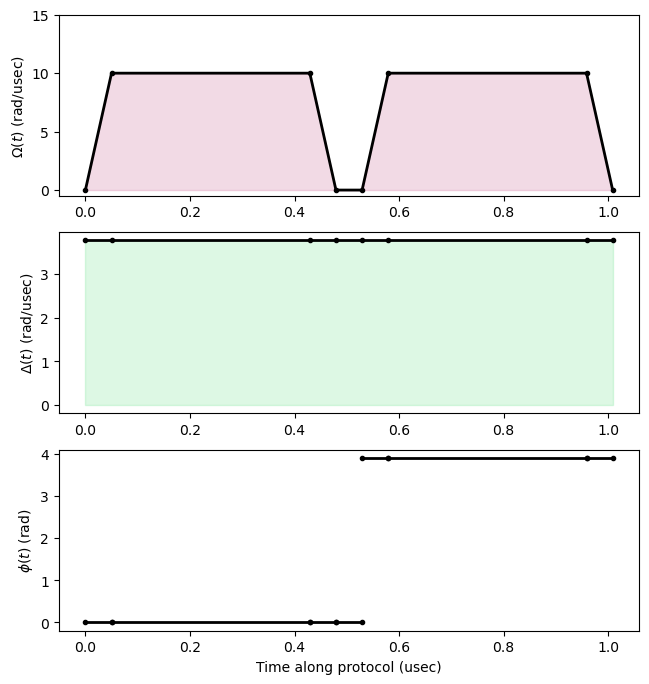

In [9]:
plot_task(lp_gate_sim_programs[-1][0])

In [ ]:
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

lp_gate_sim_tasks = [(sim.run(lp_gate_sim_program,shots=10000), None)+tuple(params) for lp_gate_sim_program,*params in lp_gate_sim_programs]

In [ ]:
import quera_ahs_utils.parallelize as pp

qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila",
)

lp_gate_qpu_programs = [pp.parallelize_ahs(lp_gate_sim_program,qpu,24e-6)+(run_time,) for lp_gate_sim_program,run_time in lp_gate_sim_programs]

In [36]:
raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, lp_gate_qpu_programs, "lp_gate_dynamics.json", shots=100)

In [20]:
from braket.aws import AwsQuantumTask
import json

lp_gate_qpu_tasks = []
with open("lp_gate_dynamics.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping, run_time = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        lp_gate_qpu_tasks.append((task,batch_mapping,run_time))

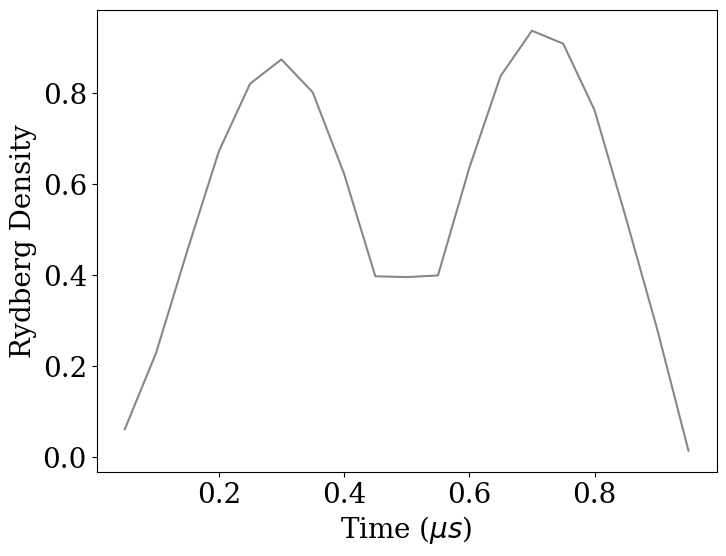

In [39]:
import matplotlib.pyplot as plt
from itertools import starmap
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = ["serif"]

def get_densities(task, batch_mapping, run_time):
    shots = pp.get_shots_braket_sdk_results(task.result(),batch_mapping=batch_mapping,post_select=False)
    
    return run_time/1e-6,1-shots.mean()

# qpu_results = list(starmap(get_densities,lp_gate_qpu_tasks))
sim_results = list(starmap(get_densities,lp_gate_sim_tasks))

# qpu_results = sorted(qpu_results,key=lambda x:x[0])
sim_results = sorted(sim_results,key=lambda x:x[0])

run_times,sim_density = zip(*sim_results)
# run_times,qpu_density = zip(*qpu_results)
sim_density = np.array(sim_density)
# qpu_density = np.array(qpu_density)


RED = "#C2477F"
PURPLE = "#6437FF"
YELLOW = "#edff1a"
YELLOW2= "#a8b512"
GREEN  = "#55de79"
BLACK  = "#878787"

plt.figure(figsize=(8,6))
plt.plot(run_times,sim_density,color=BLACK)
# plt.plot(run_times,qpu_density,color=PURPLE,linewidth=4)


plt.ylabel("Rydberg Density")
plt.xlabel("Time ($\mu s$)")
plt.savefig("LP_gate.svg")